In [1]:
# load packages and data
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F

X = torch.load('/mnt/data-a300/team_blackhole/msandora/data/X.pt')
X.shape

/tmp/ipykernel_3837212/3372241409.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load('/mnt/data-a300/team_blackhole/msandora/data/X.pt')


torch.Size([3158083, 4096])

In [144]:
# data prep
bs = 4096

ds_train, ds_val = train_test_split(X[:3*10**5],test_size=.1,random_state=4)
train_loader = torch.utils.data.DataLoader(dataset=ds_train, batch_size=bs, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=ds_val, batch_size=bs, shuffle=False)

In [148]:
# define training functions
w=1
LT = len(train_loader.dataset)
LV = len(val_loader.dataset)
   
def loss_function(x,x1,z):
    e = torch.mean(torch.sum((x1-x)**2,dim=1))
    #l = torch.mean(torch.sum(z**.1,dim=1)**1)    
    #l = torch.mean(torch.linalg.norm(z,dim=1,ord=0))
    l = torch.mean(torch.sum(torch.abs(z)>.1,dim=1).type(torch.float))
    return e+w*l

def train(epoch,verbose_step):
    sae.train()
    train_loss = 0
    train_error=0
    train_norm=0
    for batch_idx, x in enumerate(train_loader):
        x = x.cuda()
        optimizer.zero_grad()

        z,x1 = sae(x)
        e = torch.mean(torch.sum((x1-x)**2,dim=1))
        l = torch.mean(torch.sum(torch.abs(z)>.1,dim=1).type(torch.float))
        loss = e+w*l
    
        loss.backward()
        train_loss += loss.item()
        train_error += e.item()
        train_norm += l.item()
        optimizer.step()

    if epoch % verbose_step == 0:
        print('epoch: {}'.format(epoch))
        print('train loss: {:.3f}'.format(train_loss/LT),
              'train error: {:.3f}'.format(train_error/LT),
              'train norm: {:.3f}'.format(train_norm/LT))

def val(epoch):
    sae.eval()
    val_loss= 0
    val_error=0
    val_norm=0
    with torch.no_grad():
        for x in val_loader:
            x = x.cuda()
            z,x1 = sae(x)

            e = torch.mean(torch.sum((x1-x)**2,dim=1))
            l = torch.mean(torch.sum(torch.abs(z)>.1,dim=1).type(torch.float))
            loss = e+w*l
            val_loss += loss.item()
            val_error += e.item()
            val_norm += l.item()


    print('  val loss: {:.3f}'.format(val_loss/LV),
          '  val error: {:.3f}'.format(val_error/LV),
          '  val norm: {:.3f}'.format(val_norm/LV))
    return val_error+w*val_norm

def save_best(epoch, val_error, best_error):
    if epoch>0 and val_error < best_error:
        torch.save(sae.state_dict(),'../models/sae.pt')
        print('saving model')
        best_error = val_error
    return best_error

In [149]:
# define SAE model
# the model has a squeeze unsqueeze squeeze unsqueeze architecture
# for parameter efficiency
#   /\
# \/  \/
# /\  /\
#   \/
class SAE(nn.Module):
    def __init__(self, n_dim, n_squeeze, n_features):
        super(SAE,self).__init__()
        self.Wdown = nn.Linear(n_dim, n_squeeze)
        self.Wenc = nn.Linear(n_squeeze, n_features)
        self.Wdec = nn.Linear(n_features, n_squeeze)
        self.Wup = nn.Linear(n_squeeze, n_dim)
        
    def forward(self,X):
        Y = self.Wdown(X)
        #Y = F.relu(Y)
        Z = F.relu(self.Wenc(Y))
        Y = self.Wdec(Z)
        #Y = F.relu(Y)
        Y = self.Wup(Y)
        return Z, Y   
    
sae = SAE(4096,200,10000)
print('# parameters:',sum([np.prod(m.shape) for n,m in sae.named_parameters()]))
sae.cuda()


# parameters: 5652896


SAE(
  (Wdown): Linear(in_features=4096, out_features=200, bias=True)
  (Wenc): Linear(in_features=200, out_features=10000, bias=True)
  (Wdec): Linear(in_features=10000, out_features=200, bias=True)
  (Wup): Linear(in_features=200, out_features=4096, bias=True)
)

In [150]:
# train model
# can get to .1% sparsity, which isn't too bad.
verbose_step = 50
optimizer = torch.optim.AdamW(sae.parameters())

best_error = 10**800
for epoch in range(501):
    train(epoch,verbose_step)

    if epoch % verbose_step ==0:
        val_error = val(epoch)
        best_error = save_best(epoch, val_error, best_error)
sae.load_state_dict(torch.load('../models/sae.pt'))

epoch: 0
train loss: 0.826 train error: 0.260 train norm: 0.566
  val loss: 0.758   val error: 0.208   val norm: 0.550
epoch: 50
train loss: 0.634 train error: 0.072 train norm: 0.561
  val loss: 0.693   val error: 0.079   val norm: 0.614
saving model
epoch: 100
train loss: 0.455 train error: 0.072 train norm: 0.383
  val loss: 0.498   val error: 0.078   val norm: 0.419
saving model
epoch: 150
train loss: 0.367 train error: 0.072 train norm: 0.295
  val loss: 0.400   val error: 0.079   val norm: 0.321
saving model
epoch: 200
train loss: 0.306 train error: 0.072 train norm: 0.234
  val loss: 0.332   val error: 0.078   val norm: 0.254
saving model
epoch: 250
train loss: 0.184 train error: 0.183 train norm: 0.001
  val loss: 0.197   val error: 0.196   val norm: 0.001
saving model
epoch: 300
train loss: 0.169 train error: 0.168 train norm: 0.001
  val loss: 0.183   val error: 0.182   val norm: 0.002
saving model
epoch: 350
train loss: 0.147 train error: 0.144 train norm: 0.004
  val loss: 

/tmp/ipykernel_3837212/2547667990.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load('../models/sae.pt'))


<All keys matched successfully>

In [17]:
sae.load_state_dict(torch.load('../models/sae_300k.pt'))

/tmp/ipykernel_3837212/2525393300.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae.load_state_dict(torch.load('../models/sae_300k.pt'))


<All keys matched successfully>

In [40]:
# get val outputs to investigate model performance
Z = []
with torch.no_grad():
    for data in val_loader:
        data = data.cuda()
        z,x1 = sae(data)
        zg = torch.argwhere(torch.abs(z)>.1).detach().cpu().numpy()
        Z += pd.DataFrame(zg).groupby(0).agg(list)[1].tolist()
        
#Z = list(np.concatenate(Z))

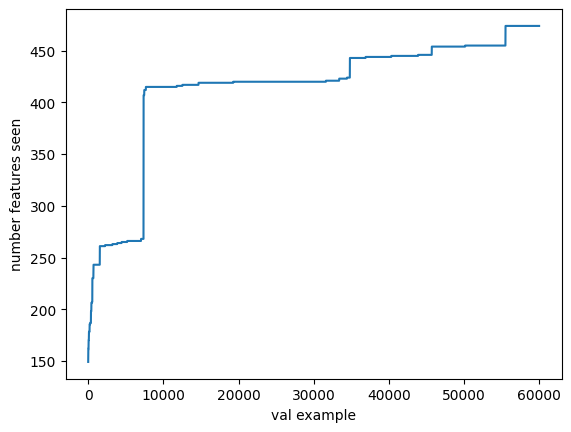

In [141]:
# plots the number of features seen vs number examples
# large vertical jumps indicate some features are still highly correlated
Ss=[]
s=set()
for z in Z:
    s = s|set(z)
    Ss.append(len(s))
    
plt.plot(Ss)
plt.xlabel('val example')
plt.ylabel('number features seen')
plt.show()

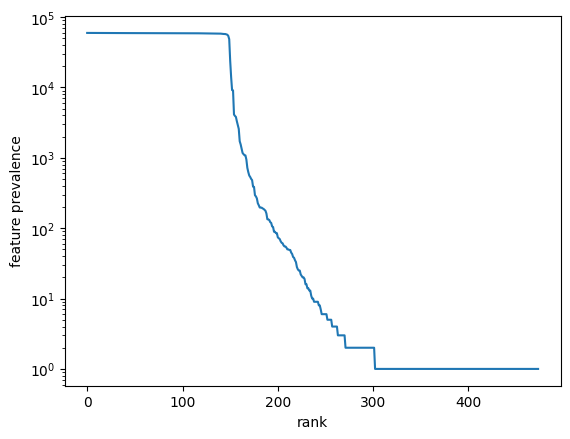

In [138]:
# statistics of feature distribution
Cs=Counter()
for z in Z:
    Cs += Counter(z)
    

plt.plot([i[1] for i in Cs.most_common()])
plt.yscale('log')
plt.xlabel('rank')
plt.ylabel('feature prevalence')
plt.show()

In [59]:
# load heart failure dataset 
df1 = pd.read_pickle('/mnt/data-a300/team_blackhole/msandora/ai-service-tools/heart_failure_mistral_embeddings.pkl')
df1 = df1.reset_index()
Y = torch.cat(df1.embeddings.tolist()).type(torch.float)
Y.shape

torch.Size([325688, 4096])

In [60]:
# run heart failure data through model and aggregate to sentence level
heart_loader = torch.utils.data.DataLoader(dataset=Y, batch_size=bs, shuffle=False)

H = []
with torch.no_grad():
    for data in heart_loader:
        data = data.cuda()
        z,x1 = sae(data)
        zg = torch.argwhere(torch.abs(z)>.1).detach().cpu().numpy()
        H += pd.DataFrame(zg).groupby(0).agg(list)[1].tolist()
        

dindex = df1.apply(lambda D: [D['index']]*D.embeddings.shape[0],axis=1).sum()
dfH = pd.DataFrame(zip(dindex,H))
dfH[1] = dfH[1].apply(set)
Hsent = dfH.groupby(0).agg(lambda x: set.union(*x))[1].tolist()

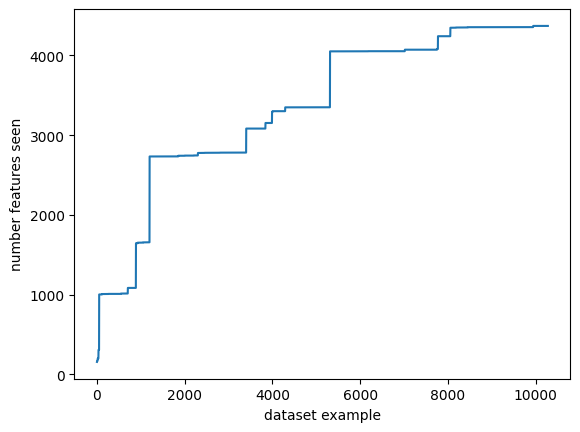

In [142]:
# number of features seen vs number of examples
hs=[]
newlies=[]
s=set()
for k,z in enumerate(Hsent):
    if len(set(z)-s)>0:
        newlies.append(k)
    s = s|set(z)
    hs.append(len(s))
    
plt.plot(hs)
plt.xlabel('dataset example')
plt.ylabel('number features seen')
plt.show()

In [97]:
len(newlies)

52

In [105]:
# 10 random sentences from dataset
df1.sample(10).sentence_text.tolist()

['Lungs and Pleural Spaces: Mild pulmonary vascular congestion and a small right pleural effusion appears stable.',
 'Lungs/Pleural Spaces: Patchy interstitial pneumonitis/edema bilaterally without significant change.',
 'Lungs/Pleural Spaces: Increased pulmonary vascular congestion.',
 'Heart/Mediastinum: Mild to moderate prominence of the bilateral interstitial markings/pulmonary vascular congestion.',
 ' Diffuse airspace disease with a differential diagnosis which includes ARDS, edema and/or pneumonia.',
 ' Findings suggest worsening congestive heart failure.',
 'Lungs and Pleural Spaces: Vascular congestion persists.',
 'Lungs and Pleural Spaces: Moderate pulmonary vascular congestion, slightly increased since previously.',
 'Lungs and Pleural Spaces: Previously noted pulmonary vascular congestion has markedly improved.',
 'Lungs and Pleural Spaces: Questionable mild\npulmonary vascular congestion']

In [143]:
# 10 sentences exhibiting novelty from dataset
# look to be more diverse than random sentences
df1.iloc[newlies].sample(10).sentence_text.tolist()

[' Findings could represent early pulmonary edema.',
 ' CONGESTIVE HEART FAILURE',
 "Lungs/Pleural Spaces: Mild interstitial pulmonary edema is noted which is exacerbated by the poor inspiration and the patient's body habitus.",
 'Abdominal/Pelvic Wall: Diffuse soft tissue edema and muscle atrophy.',
 'Lungs: Alveolar edema on the background of air trapping is also a consideration. [SEP] Lungs: The denser areas of the lung parenchyma may be due to alveolar edema or the effects of diminished lung volumes with air trapping accounting for the areas of relative decreased parenchymal attenuation. [SEP] Mediastinum: There is edema in the mediastinal fat. [SEP]  Others could be due to alveolar edema or air trapping, a combination thereof is of concern.',
 ' Findings are nonspecific but may be seen with pulmonary edema or other interstitial process',
 ' More vascular congestion is noted than previously. [SEP]  Increasing vascular congestion.',
 'Lung fields: There are redemonstrated bilateral 

In [106]:
# define feature counter for heart failure dataset
HC=Counter()
for z in Hsent:
    HC += Counter(z)
    
[(h,c) for h,c in HC.most_common() if c==24]

In [126]:
# are features interpretable? spot check/cherry pick
for s in df1.iloc[[k for k,h in enumerate(Hsent) if 4659 in h]].sentence_text.tolist()[:4]:
    print(s)
    print('---')

Lungs and Pleural Spaces: There is increasing accentuation of the central bronchovascular markings and indistinctness of pulmonary vessels suggesting worsening vascular congestion.
---
 There has been interval development of accentuation of central bronchovascular markings and peribronchial cuffing which may relate to developing edema/bronchitis.
---
Lungs and Pleural Spaces: There are increasing perihilar airspace opacities, right greater than left, compatible with pulmonary edema pattern. [SEP] Lungs and Pleural Spaces: There is indistinctness and prominence of the pulmonary vessels indicating pulmonary vascular congestion.
---
Lungs/Pleural Spaces: There are increased interstitial markings throughout both lungs which may be related to underlying interstitial edema pattern [SEP] Lungs/Pleural Spaces: There is accentuation of the central bronchovascular markings and indistinctness pulmonary vessels compatible with underlying pulmonary vascular congestion.
---


In [128]:
# are features interpretable? spot check/cherry pick
for s in df1.iloc[[k for k,h in enumerate(Hsent) if 4452 in h]].sentence_text.tolist()[:4]:
    print(s)
    print('---')

 There has been interval development of accentuation of central bronchovascular markings and peribronchial cuffing which may relate to developing edema/bronchitis.
---
Lungs/Pleural Spaces: Mild interstitial pulmonary edema is noted which is exacerbated by the poor inspiration and the patient's body habitus.
---
 Both findings could be accounted for by pulmonary edema. [SEP]  Groundglass opacities could represent pulmonary edema, hemorrhage, infection or other inflammatory process.
---
Lungs/Pleural Spaces: Mild pulmonary vascular congestion is again noted which is exacerbated by the poor inspiration and the patient's body habitus.
---


In [130]:
# are features interpretable? spot check/cherry pick
for s in df1.iloc[[k for k,h in enumerate(Hsent) if 975 in h]].sentence_text.tolist()[:4]:
    print(s)
    print('---')

Lungs: Alveolar edema on the background of air trapping is also a consideration. [SEP] Lungs: The denser areas of the lung parenchyma may be due to alveolar edema or the effects of diminished lung volumes with air trapping accounting for the areas of relative decreased parenchymal attenuation. [SEP] Mediastinum: There is edema in the mediastinal fat. [SEP]  Others could be due to alveolar edema or air trapping, a combination thereof is of concern.
---
Lungs: Mosaic attenuation, which can be seen in air trapping, subsegmental atelectasis, or edema. [SEP]  Bilateral pulmonary opacities, which may represent subsegmental atelectasis, edema, or aspiration/pneumonia.
---
 Opacities along both lung bases, and along the central lung zones, bilaterally are decreased from previous, which may correspond to atelectasis, pulmonary edema, or possibly to infiltrates.
---
 Patchy opacities diffusely throughout both lungs most suggestive of pulmonary edema, less likely an infectious etiology.
---
